## EDA of time series for data modeling and prediction of phasor info in power grid.

In [ ]:
#Loading the Drive helper and mount
from google.colab import drive
#HERE Will prompt for authorisation
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# librairies

from __future__ import absolute_import, division, print_function, unicode_literals

import pandas as pd
import numpy as np
import math

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as mpl
import plotly.graph_objs as go
import plotly.express as px


from datetime import datetime

from pylab import rcParams
#mpl.rcParams['figure.figsize']= (10,8)
mpl.rcParams['axes.grid']= False

import warnings
warnings.filterwarnings("ignore")

In [ ]:
path = '/content/drive/My Drive/master_thesis/Dataset/mycsvfile.csv'

def convert_to_date(x):
  return datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
  
df = pd.read_csv(path, parse_dates=['time'], date_parser=convert_to_date, keep_date_col=True)
df.head()

,time,phasor_diff1,phasor_diff2,phasor_diff3,PV_hoch,PV_prog
0,2020-01-07 00:00:00,0.101091,0.054101,0.956162,0.0,0.0
1,2020-01-07 00:15:00,0.092844,0.040110,0.953309,0.0,0.0
2,2020-01-07 00:30:00,0.099271,0.043656,0.953645,0.0,0.0
3,2020-01-07 00:45:00,0.095014,0.042996,0.952869,0.0,0.0
4,2020-01-07 01:00:00,0.120647,0.059410,0.955343,0.0,0.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25730 entries, 0 to 25729
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   time          25730 non-null  datetime64[ns]
 1   phasor_diff1  25730 non-null  float64       
 2   phasor_diff2  25730 non-null  float64       
 3   phasor_diff3  25728 non-null  float64       
 4   PV_hoch       25730 non-null  float64       
 5   PV_prog       25730 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 1.2 MB


In [ ]:
print("Rows :" , df.shape[0])
print("Columns :" , df.shape[1])
print("\nFeatures : \n" , df.columns.tolist())
print("\nMissing Values : \n" , df.isnull().any())
print("\nUnique Values : \n" , df.nunique())

Rows : 25730
Columns : 6

Features : 
 ['time', 'phasor_diff1', 'phasor_diff2', 'phasor_diff3', 'PV_hoch', 'PV_prog']

Missing Values : 
 time            False
phasor_diff1    False
phasor_diff2    False
phasor_diff3     True
PV_hoch         False
PV_prog         False
dtype: bool

Unique Values : 
 time            25728
phasor_diff1    25730
phasor_diff2    25730
phasor_diff3    25728
PV_hoch         15009
PV_prog         14933
dtype: int64


In [ ]:
df.describe()

,phasor_diff1,phasor_diff2,phasor_diff3,PV_hoch,PV_prog
count,25730.000000,25730.000000,25728.000000,25730.000000,25730.000000
mean,-0.428652,0.095217,0.737645,4190.637431,4221.136928
std,0.378404,0.327817,0.200338,5741.733984,5762.543653
min,-0.999904,-0.999844,-0.995893,0.000000,0.000000
25%,-0.750395,-0.104858,0.608249,0.000000,0.000000
50%,-0.484100,0.103885,0.765444,497.229500,535.660000
75%,-0.141554,0.317812,0.896351,7587.584500,7727.865000
max,0.995455,0.997722,0.998964,21944.654000,21410.620000


###### Because of missing data in the beginning of January 2020, let's analyze data from February 2020 for better prediction performance.

In [ ]:
other_df = df.set_index('time')

In [ ]:
other_df_copy = other_df.copy()
other_df_copy = other_df_copy.reset_index()
time_from_feb = (other_df_copy['time'] >= ('2020-02-01 00:00:00')) & (other_df_copy['time'] <= ('2020-09-30 23:45:00'))

In [ ]:
other_df_feb = other_df_copy.loc[time_from_feb]
other_df_feb = other_df_feb.set_index('time')
other_df_feb.head()

,phasor_diff1,phasor_diff2,phasor_diff3,PV_hoch,PV_prog
time,,,,,
2020-02-01 00:00:00,0.175611,-0.022638,0.964870,0.0,0.0
2020-02-01 00:15:00,0.191028,-0.030691,0.967817,0.0,0.0
2020-02-01 00:30:00,0.185786,-0.026717,0.967107,0.0,0.0
2020-02-01 00:45:00,0.197130,-0.030612,0.969416,0.0,0.0
2020-02-01 01:00:00,0.171353,-0.020959,0.965252,0.0,0.0


In [ ]:
# start and end dates of the time series
print ("dataset: start_date = {}, end_date = {} \n".format(other_df_feb.index.min(), other_df_feb.index.max()))

dataset: start_date = 2020-02-01 00:00:00, end_date = 2020-09-30 23:45:00 



In [ ]:
from_feb_df = other_df_feb.copy()
from_feb_df['month'] = [i.month for i in from_feb_df.index]
from_feb_df['day'] = [i.day for i in from_feb_df.index]
from_feb_df['hour'] = [i.hour for i in from_feb_df.index]
from_feb_df.head()

,phasor_diff1,phasor_diff2,phasor_diff3,PV_hoch,PV_prog,month,day,hour
time,,,,,,,,
2020-02-01 00:00:00,0.175611,-0.022638,0.964870,0.0,0.0,2,1,0
2020-02-01 00:15:00,0.191028,-0.030691,0.967817,0.0,0.0,2,1,0
2020-02-01 00:30:00,0.185786,-0.026717,0.967107,0.0,0.0,2,1,0
2020-02-01 00:45:00,0.197130,-0.030612,0.969416,0.0,0.0,2,1,0
2020-02-01 01:00:00,0.171353,-0.020959,0.965252,0.0,0.0,2,1,1


In [ ]:
from_feb_df[['month', 'phasor_diff1']].groupby('month').describe()

phasor_diff1                      ...                              
             count      mean       std  ...       50%       75%       max
month                                   ...                              
2           2784.0 -0.054087  0.293122  ...  0.027079  0.173343  0.526493
3           2976.0 -0.232135  0.299798  ... -0.262660  0.016767  0.992605
4           2881.0 -0.562243  0.304138  ... -0.624113 -0.348723  0.444034
5           2976.0 -0.673909  0.228879  ... -0.720248 -0.541906  0.830193
6           2880.0 -0.701352  0.253103  ... -0.773287 -0.574040  0.923747
7           2976.0 -0.458708  0.293136  ... -0.513480 -0.276321  0.989733
8           2977.0 -0.594122  0.320141  ... -0.662564 -0.384685  0.995417
9           2880.0 -0.558524  0.269015  ... -0.584530 -0.391558  0.995455

[8 rows x 8 columns]

In [ ]:
from_feb_df[['month', 'phasor_diff1', 'PV_hoch']].groupby('month').agg({'phasor_diff1':['min','max'], 'PV_hoch':['min', 'max']})

phasor_diff1           PV_hoch           
               min       max     min        max
month                                          
2        -0.917715  0.526493     0.0  11740.034
3        -0.980712  0.992605     0.0  20633.810
4        -0.998710  0.444034     0.0  21081.432
5        -0.997278  0.830193     0.0  21172.459
6        -0.999904  0.923747     0.0  21944.654
7        -0.992404  0.989733     0.0  20678.871
8        -0.999867  0.995417     0.0  20659.757
9        -0.999388  0.995455     0.0  18607.044

#### Data distribution

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6b3e28b910>,
      dtype=object)

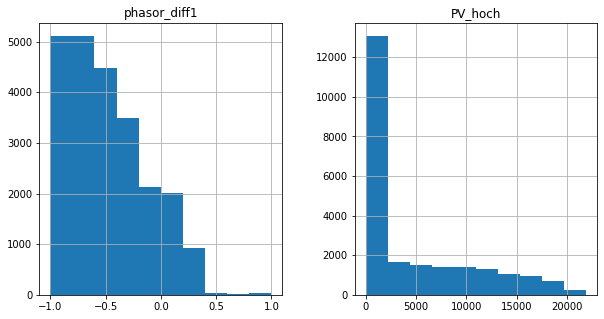

In [ ]:
rcParams['figure.figsize'] = 10, 5
from_feb_df[['phasor_diff1', 'PV_hoch']].hist()

#### Info on phasor angle in power grid to support our analysis

https://www.gses.com.au/wp-content/uploads/2016/03/GSES_powerfactor-110316.pdf

https://www.sma.de/en/partners/knowledgebase/sma-shifts-the-phase.html



##### => most values are negative for phasor_diff1: higher frequency of negative values
##### => as the value becomes higher, the frequency reduces for PV infeed: higher frequency for low PV infeed (night hours without solar energy as previously observed in heatmap visualization)

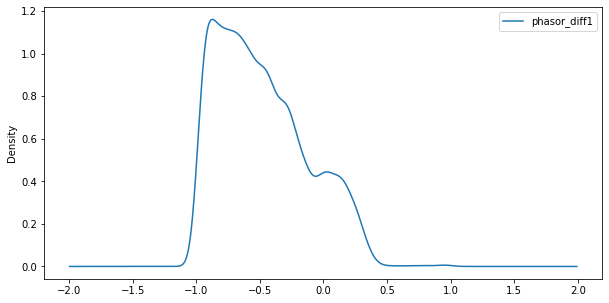

In [ ]:
rcParams['figure.figsize'] = 10, 5
from_feb_df[['phasor_diff1']].plot(kind='density')

#### Autocorrelation

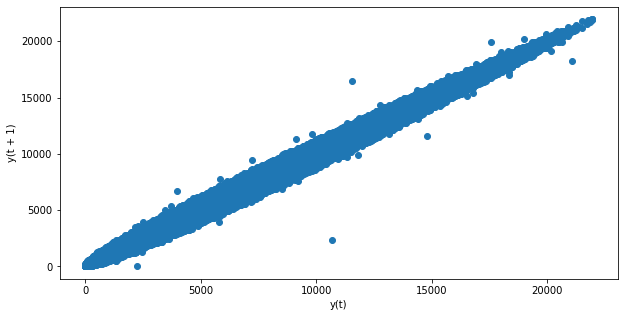

In [ ]:
rcParams['figure.figsize'] = 10, 5
pd.plotting.lag_plot(from_feb_df['PV_hoch'], lag=1)

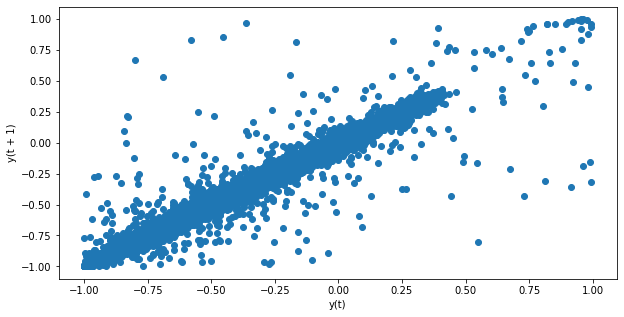

In [ ]:
rcParams['figure.figsize'] = 10, 5
pd.plotting.lag_plot(from_feb_df['phasor_diff1'], lag=1)

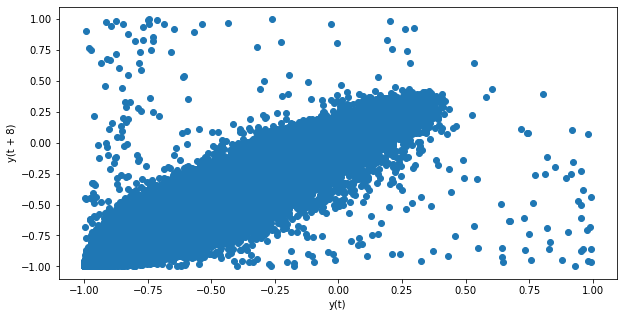

In [ ]:
rcParams['figure.figsize'] = 10, 5
pd.plotting.lag_plot(from_feb_df['phasor_diff1'], lag=8) #lag4:15min

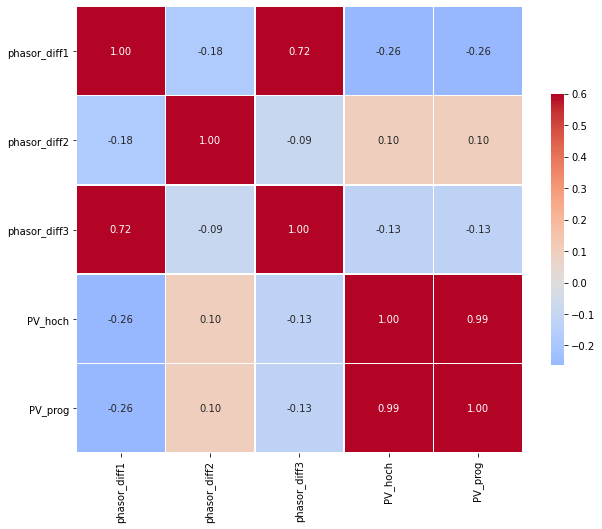

In [ ]:
from_feb_df_corr = from_feb_df[['phasor_diff1', 'phasor_diff2', 'phasor_diff3', 'PV_hoch', 'PV_prog']].corr(method="pearson")

g = sns.heatmap(from_feb_df_corr, vmax=0.6, center=0,
                square=True, linewidths=0.5, cbar_kws={"shrink": 0.5}, annot=True, fmt='.2f', cmap='coolwarm')

g.figure.set_size_inches(10, 10)

plt.show()

#### autocorrelation with confidence level

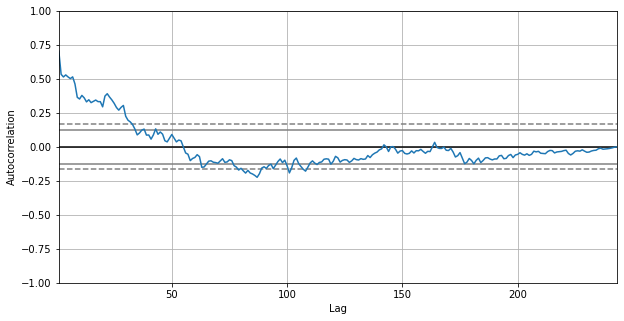

In [ ]:
rcParams['figure.figsize'] = 10, 5
pd.plotting.autocorrelation_plot(from_feb_df['phasor_diff1'].resample("1d").mean())

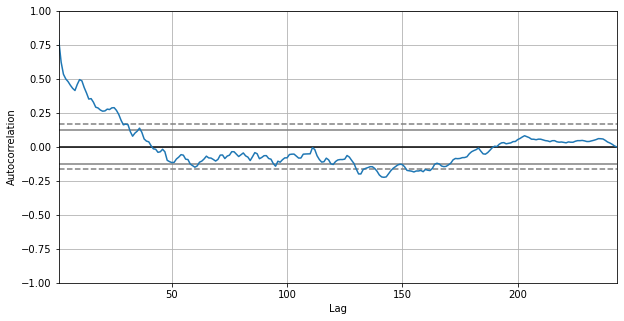

In [ ]:
rcParams['figure.figsize'] = 10, 5
pd.plotting.autocorrelation_plot(from_feb_df['PV_hoch'].resample("1d").mean())

#### Heatmap visualization of our new data from February 2020 to September 2020.

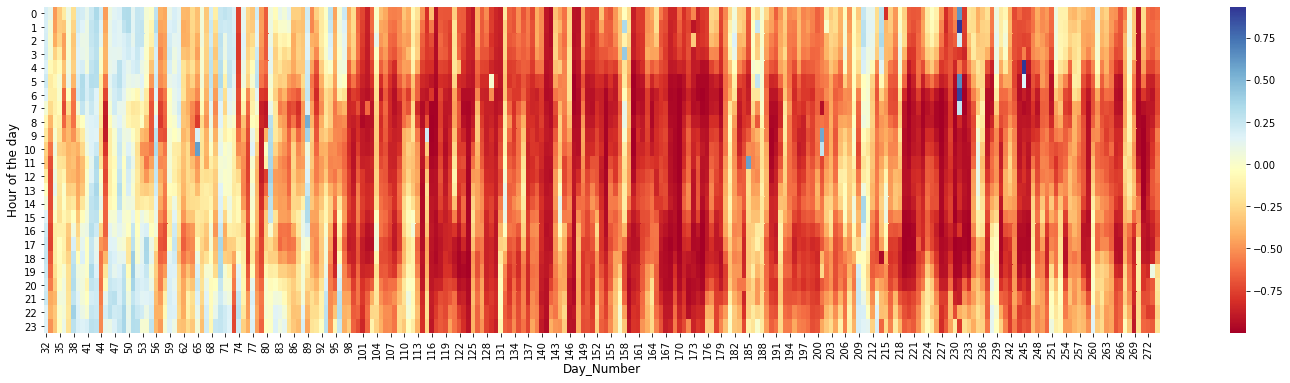

In [ ]:
heatmap_df = from_feb_df.copy()

#Create variables for Day and hour
heatmap_df['Day'] = [i.dayofyear for i in heatmap_df.index]
heatmap_df['hour'] = [i.hour for i in heatmap_df.index]

#Group by day and hour and aggregate
heatmap_df = heatmap_df.groupby(['Day','hour']).mean()

#Use unstack function to prepare the data to be plotted
heatmap_df= heatmap_df['phasor_diff1'].unstack(level=0)

fig, ax = plt.subplots(figsize=(25, 6))

fig.canvas.draw()
cmap = 'RdYlBu'


sns.heatmap(heatmap_df, cmap=cmap)

#plt.title('Herzogenrath_Schondorf \n (Jan 2020 - Sept 2020)', fontweight='bold', fontsize = 14)
#plt.title('Bremen_Schondorf', fontweight='bold', fontsize = 14)
plt.xlabel("Day_Number", fontsize=12)
plt.ylabel("Hour of the day", fontsize=12)

plt.yticks(rotation=0)
#plt.xticks('Day -' + from_jan_2020.Day)

labels = [item.get_text() for item in ax.get_xticklabels()]
#labels[2] = 'Day -'

ax.set_xticklabels(labels)
plt.show()

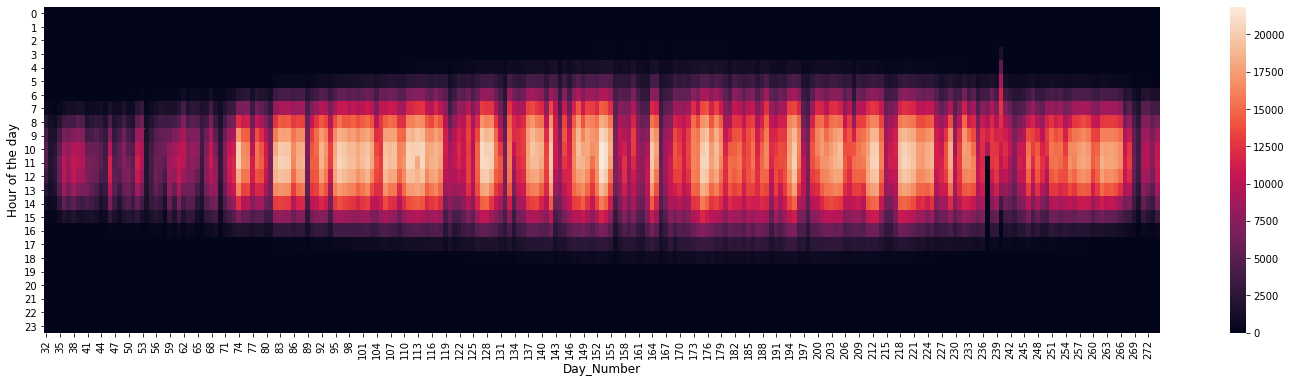

In [ ]:
heatmap_df = from_feb_df.copy()

#Create variables for Day and hour
heatmap_df['Day'] = [i.dayofyear for i in heatmap_df.index]
heatmap_df['hour'] = [i.hour for i in heatmap_df.index]

#Group by day and hour and aggregate
heatmap_df = heatmap_df.groupby(['Day','hour']).mean()

#Use unstack function to prepare the data to be plotted
heatmap_df= heatmap_df['PV_hoch'].unstack(level=0)

fig, ax = plt.subplots(figsize=(25, 6))

fig.canvas.draw()
#cmap = 'RdYlBu'


sns.heatmap(heatmap_df, vmin=0)

#plt.title('Herzogenrath_Schondorf \n (Jan 2020 - Sept 2020)', fontweight='bold', fontsize = 14)
#plt.title('Bremen_Schondorf', fontweight='bold', fontsize = 14)
plt.xlabel("Day_Number", fontsize=12)
plt.ylabel("Hour of the day", fontsize=12)

plt.yticks(rotation=0)
#plt.xticks('Day -' + from_jan_2020.Day)

labels = [item.get_text() for item in ax.get_xticklabels()]
#labels[2] = 'Day -'

ax.set_xticklabels(labels)
plt.show()

### Dataset to use for prediction.

#### => We will predict phasor information of Bremen_Schondorf (phasor_diff1) location using solar energy information as well.

In [ ]:
final_df = other_df_feb.copy()
final_df = final_df[['phasor_diff1','PV_hoch']]
final_df.head(10)

,phasor_diff1,PV_hoch
time,,
2020-02-01 00:00:00,0.175611,0.0
2020-02-01 00:15:00,0.191028,0.0
2020-02-01 00:30:00,0.185786,0.0
2020-02-01 00:45:00,0.197130,0.0
2020-02-01 01:00:00,0.171353,0.0
2020-02-01 01:15:00,0.203891,0.0
2020-02-01 01:30:00,0.187335,0.0
2020-02-01 01:45:00,0.205745,0.0
2020-02-01 02:00:00,0.208079,0.0


#### Visualization of phasor info and solar energy over time

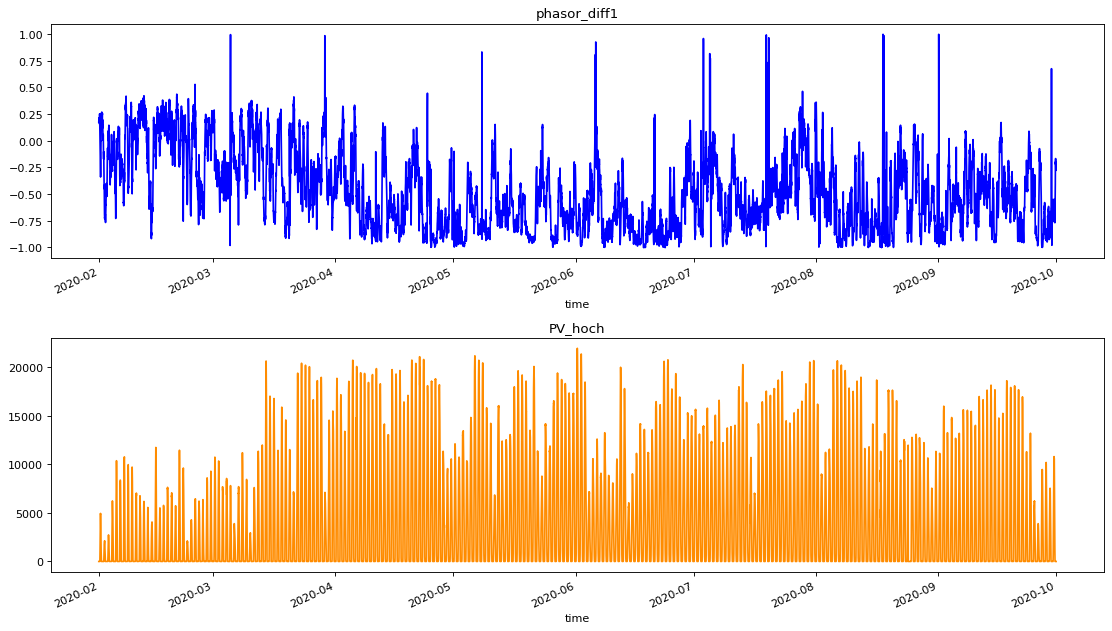

In [ ]:
color_list = ["blue", "darkorange"]

def visualization(data):
  features = list(final_df.select_dtypes(include=[np.number]).columns.values)
  feature_size = len(features)
  fig, axes = plt.subplots(
      nrows = int(np.ceil(feature_size/1)), ncols=1, figsize=(14, feature_size*4), dpi=80, facecolor="w", edgecolor="k"
  )

  for i in range(feature_size):
    key = features[i]
    c = color_list[i % (len(color_list))]
    t_data = data[key]
    t_data.head()
    ax = t_data.plot(
        #ax = axes[i//2, i%2],
        ax = axes[i%2],
        color = c,
        title = "{}".format(key),
        rot=25,
    )

    #ax.legend([key])
  plt.tight_layout()

visualization(final_df)

In [ ]:
final_df.to_csv("dataset.csv", index=True)